In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from glob import glob
from tips.io import load_ds

def unique_legend(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), **kwargs)

In [2]:
exp = '../exp/scan/'

In [ ]:
logs = glob(f'{exp}/models/gen*/model1/pinn.log')
gen = [int(re.search('gen(\d+)', l)[1]) for l in logs]
err = [np.loadtxt(l)[-1] for l in logs]
logs = np.array([[g,*e] for  g, e in zip(gen, err)])
pinn_logs = logs[logs[:,0].argsort()]

In [4]:
logs = glob(f'{exp}/md/gen*/m0i32-r1.08/asemd.log')
gen = [int(re.search('gen(\d+)', l)[1]) for l in logs]
scale = [np.loadtxt(l, skiprows=1)[-1,0] for l in logs]
logs = np.array([*zip(gen,scale)])
md_logs = logs[logs[:,0].argsort()]

In [ ]:
natom = 640
logs = glob(f'{exp}/md/gen*/m0i32-r1.08/asemd.log')
gen = sorted([int(re.search('gen(\d+)', l)[1]) for l in logs])
f_rmse, e_rmse = [], []
for g in gen:
    print(g)
    e_se = []
    f_se = []
    for fidx in glob(f'{exp}/merge/gen{g}/*/merged.idx'):
        idx = np.loadtxt(fidx, int)
        isort = np.argsort(idx)
        init = re.search('gen\d+/(.*)/merged.idx', fidx)[1]
        label = load_ds(f'{exp}/merge/gen{g}/{init}/merged.traj', fmt='asetraj')
        e_label = np.array([l['energy'] for l in label])[isort] / natom
        f_label = np.array([l['force'] for l in label])[isort]
        ftraj = f'{exp}/md/gen{g}/{init}/asemd.traj'
        traj = load_ds(ftraj, fmt='asetraj', index=f':{idx[isort[-1]]+1}:{idx[isort[1]]}')
        e_model = np.array([datum['energy'] for datum in traj]) / natom
        f_model = np.array([datum['force'] for datum in traj])
        e_se.append(np.mean((e_model-e_label)**2))
        f_se.append(np.mean((f_model-f_label)**2))
    f_rmse.append(np.sqrt(np.mean(f_se))*1e3)
    e_rmse.append(np.sqrt(np.mean(e_se))*1e3)

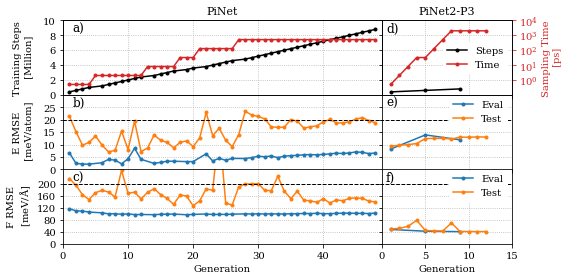

In [14]:
f, axs = plt.subplots(3, 2, 
                      figsize=[8,4], 
                      sharex='col', 
                      gridspec_kw={
                          'hspace':0,
                          'wspace':0,
                          'width_ratios': [49, 20]
                      })


for idx, ((ax1, ax2, ax3), model) in enumerate(zip(
    axs.T,
    ['scan_pinet', 'scan_pinet2-p3'])):
    
    dat_train = np.loadtxt(f'{model}_train.dat')
    dat_md = np.loadtxt(f'{model}_md.dat')
    dat_train = dat_train[dat_train[:,0]<48]
    dat_md = dat_md[dat_md[:,0]<48]
    
    tax = ax1.twinx()
    l1, = ax1.plot(dat_train[:,0]+1, dat_train[:,1], 'k.-')
    l2, = tax.plot(dat_md   [:,0]+1, dat_md   [:,1], '.-', color='tab:red')
    l3, = ax2.plot(dat_train[:,0]+1, dat_train[:,2], '.-', color='tab:blue')
    l4, = ax2.plot(dat_md   [:,0]+1, dat_md   [:,2], '.-', color='tab:orange')
    l5, = ax3.plot(dat_train[:,0]+1, dat_train[:,3], '.-', color='tab:blue')
    l6, = ax3.plot(dat_md   [:,0]+1, dat_md   [:,3], '.-', color='tab:orange')
    
    ax2.plot([-10,50], [20,20], 'k--', lw=1)
    ax3.plot([-10,50], [200,200], 'k--', lw=1)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    
    tax.set_yscale('log')

    ax3.set_xlabel('Generation')
    ax1.set_yticks(np.arange(0,11,2))
    ax2.set_yticks(np.arange(0,30,5))
    ax3.set_yticks(np.arange(0,240,40))
    if idx==0:
        tax.set_yticks([])
        ax1.set_ylabel('Training Steps\n [Million]')
        ax2.set_ylabel('E RMSE\n [meV/atom]')
        ax3.set_ylabel('F RMSE\n [meV/$\AA$]')
    else:
        tax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
        tax.set_ylabel('Sampling Time\n [ps]', color='tab:red')
        tax.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        leg1 = ax1.legend([l1, l2], ['Steps', 'Time'],frameon=True, bbox_to_anchor=(1, 0.5), loc=5, edgecolor='white',facecolor='white', framealpha=1)
        leg2 = ax2.legend([l3, l4], ['Eval', 'Test'], frameon=True, bbox_to_anchor=(1, 1.05), loc=1, edgecolor='white',facecolor='white', framealpha=1)
        leg3 = ax3.legend([l5, l6], ['Eval', 'Test'], frameon=True, bbox_to_anchor=(1, 1.05), loc=1, edgecolor='white',facecolor='white', framealpha=1)
        
    ax1.set_xlim(0,[49,15][idx])
    ax1.set_ylim(0,10)
    ax2.set_ylim(0,30)
    ax3.set_ylim(0,249)
    tax.set_ylim(0.1,1e4)
    ax1.set_title(
        ("PiNet", "PiNet2-P3")[idx], fontsize=11)

    for label, ax in zip(('abc','def')[idx], (ax1, ax2, ax3)):
        t = ax.text(0.03,0.98, f'{label})', transform=ax.transAxes, va='top',
                    fontsize=12)
    f.align_ylabels()
    plt.tight_layout()
    plt.savefig(f'../figs/pils-logs-combined.png')

In [6]:
np.savetxt(
    'scan_pinet2-p3_train.dat',
    np.stack(
        [pinn_logs[:,0], 
         pinn_logs[:,1]/1e6, 
         pinn_logs[:,2]*1e3,
         pinn_logs[:,4]*1e3]
    ).T)

np.savetxt(
    'scan_pinet2-p3_md.dat',
    np.stack(
        [md_logs[:,0], 
         md_logs[:,1],
         e_rmse,
         f_rmse]).T)